In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

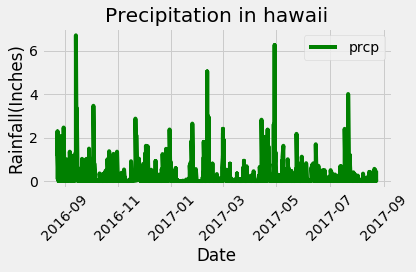

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
current_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)

for tmp in current_date:
    final_date = tmp.date
final_date = dt.datetime.strptime(final_date, "%Y-%m-%d")
# Calculate the date 1 year ago from the last data point in the database
date_1YearAgo = final_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
data_final_prec = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_1YearAgo).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
m_dataframe = pd.DataFrame(data_final_prec).dropna()
# Sort the dataframe by date
m_dataframe['date'] = pd.to_datetime(m_dataframe['date'])
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(m_dataframe['date'], m_dataframe['prcp'],'g')
plt.xlabel('Date'); plt.ylabel('Rainfall(Inches)')
plt.legend(bbox_to_anchor=(1.00, 1.00))
plt.xticks(rotation='45')
plt.title("Precipitation in hawaii")
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
m_dataframe.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station=pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by('count DESC').all(),columns=["Station","No. of Measurements"])
station

E:\Anaconda\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


,Station,No. of Measurements
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station,func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by('count DESC').limit(1)[0][0]
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

tt = session.query(*sel).filter(Measurement.station == most_active_station).all()
tt

[(54.0, 85.0, 71.66378066378067)]

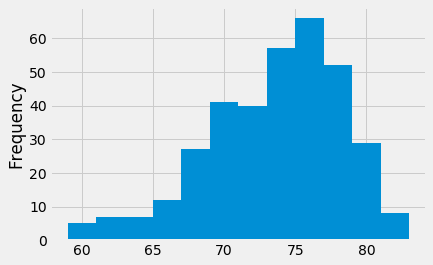

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.tobs).filter(Measurement.station==most_active_station).filter(Measurement.date >= date_1YearAgo).order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_active_tobs]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2016-01-01', '2016-01-15')
temps

[(62.0, 69.70786516853933, 78.0)]

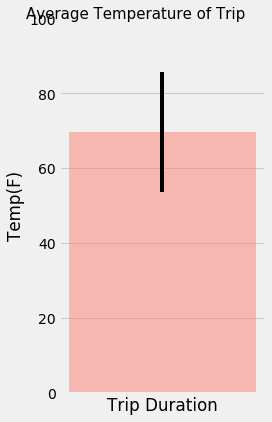

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][0]
upper = temps[0][2]

plt.figure(figsize=(4,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp(F)")
plt.xlabel("Trip Duration")
# plt.grid(color='g', linestyle='-', linewidth=1,)
plt.suptitle("Average Temperature of Trip", size = 15)
plt.tight_layout()
plt.show()

In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station,Station.name,Station.latitude, Station.longitude,
                         Station.elevation,Measurement.prcp.label('rainfall')).group_by(Measurement.station).join(Station, Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).order_by('rainfall DESC').all()

rainfall('2016-08-23', '2016-09-07')


[(u'USC00516128',
  u'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.35),
 (u'USC00514830',
  u'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.23),
 (u'USC00519281',
  u'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.16),
 (u'USC00519523',
  u'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.11),
 (u'USC00513117', u'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1),
 (u'USC00519397', u'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05),
 (u'USC00517948', u'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_day = 1
end_day = 7
# Use the start and end date to create a range of dates
day_range = end_day - start_day

# Stip off the year and save a list of %m-%d strings
days = ["01-0"+str(x) for x in range(start_day, end_day+1)]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(x) for x in days]
normals

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)]]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = np.array(normals)
normals = np.squeeze(normals)
tt= [pd.to_datetime(dt.datetime.strptime("2018-"+x, "%Y-%m-%d")) for x in days]
daily_normals_dataFrame = pd.DataFrame()
daily_normals_dataFrame["date"] = tt
daily_normals_dataFrame["tmin"] = normals[:,0]
daily_normals_dataFrame["tavg"] = normals[:,1]
daily_normals_dataFrame["tmax"] = normals[:,2]
daily_normals_dataFrame.head()

,date,tmin,tavg,tmax
0,2018-01-01,62.0,69.153846,77.0
1,2018-01-02,60.0,69.396226,77.0
2,2018-01-03,62.0,68.909091,77.0
3,2018-01-04,58.0,70.000000,76.0
4,2018-01-05,56.0,67.964286,76.0


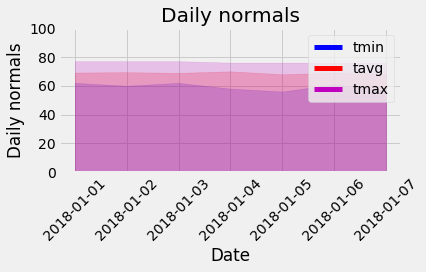

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
plt.clf()
plt.plot([],[],color='b', label='tmin', linewidth=5)
plt.plot([],[],color='r', label='tavg', linewidth=5)
plt.plot([],[],color='m', label='tmax', linewidth=5)

plt.stackplot(np.array(daily_normals_dataFrame["date"]), np.array(daily_normals_dataFrame["tmin"]),color='b',alpha = 0.2)
plt.stackplot(np.array(daily_normals_dataFrame["date"]),np.array(daily_normals_dataFrame["tavg"]),color='r',alpha = 0.2)
plt.stackplot(np.array(daily_normals_dataFrame["date"]), np.array(daily_normals_dataFrame["tmax"]),color='m',alpha = 0.2)

plt.xlabel('Date'); plt.ylabel('Daily normals')
plt.legend()
plt.xticks(rotation='45')
plt.title("Daily normals")
plt.tight_layout()
# plt.xticks(np.array(daily_normals_dataFrame["date"]))
plt.ylim(0,100)
plt.show()